In [1]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from ultralytics import YOLO

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
IMG_SIZE = 24
FRAME = 10
BATCH_SIZE = 1
CHANNEL = 5
# DATA_GROUP_TIME = 1 # time (in seconds) in which all EEG attention data and blink rate data will be grouped in order to be compared
SAMPLING_WINDOW_TIME = 1 # window of time (in seconds) in which samples will be taken from to calculate blink probability
SAMPLE_NUM = 2 # number of samples that will be taken from the sampling window
OVERLAP_FRAMES = 0 # number of frames that will be overlapped when creating sequence
PRED_MODE = 'or' # 'or', 'and', 'average': mode in which the predictions of both eyes will be combined to make blink prediction

if ((SAMPLING_WINDOW_TIME*30-FRAME)/SAMPLE_NUM)<1:
    print("ERROR! SAMPLE_NUM and FRAME too great compared to SAMPLING_WINDOW_TIME!")

In [4]:
MODEL  = './yolov8n-face.pt' # load yolo model
model_y = YOLO(MODEL)

best_model = keras.models.load_model('./model/VIT_1') # load vit model

# V2. get both blink prediction and attention score from one inference of combined model

In [5]:
# calculate sampling step from sampling window time, number of frames in sequence, and sample number OR manually set sampling step
# samp_step=int((SAMPLING_WINDOW_TIME*30-FRAME)/SAMPLE_NUM) # calculate samp_step from other variables
samp_step=5 # manually set samp_step

samp_step

5

In [6]:
PRED_MODE = 'average' # 'or', 'and', 'average': mode in which the predictions of both eyes will be combined to make blink prediction

In [7]:
# Extract the layer that provides attention scores
attention_layer = best_model.layers[-8].output  # Adjust based on your model architecture

# Create a new model that outputs both the blink prediction and attention scores
combined_model = tf.keras.Model(inputs=best_model.input, outputs=[best_model.output, attention_layer])

In [8]:
# Function for image preprocessing

@tf.function
def get_img(img, mode='test', trans = [0, 2, 1, 3]):
    
    # img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.rgb_to_grayscale(img)

    if mode =='train':
        img = tf.image.random_flip_left_right(img)
        
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.per_image_standardization(img)

    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE*FRAME))
    img = tf.reshape(img, (IMG_SIZE, FRAME,IMG_SIZE, 1))
    img = tf.transpose(img, trans)
    
    img2 = (img - img[:,:,0:1, :]) # residual embedding
    img3 = (img - img[:,:,9:, :])
    img4 = (img - img[:,:,4:5, :])
    img5 = (img - img[:,:,5:6, :])

    return tf.concat([img, img2, img3, img4, img5], axis=-1)

In [9]:
# Functions for processing of images, coordinates, and outputs

# take output of YOLOv8 face and turn it into eye location coordinates
def getcoord(output):

    detection_count=output[0].boxes.shape[0] # check if landmarks were detected
    if detection_count != 0: # if something was detected:
        keypoints=output[0].keypoints.cpu().numpy() # get keypoints from results (facial landmarks)
        if max(keypoints.conf.sum(axis=1))>3.5:
            # keypoints=result.keypoints.numpy() # get keypoints from results (facial landmarks)
            keep_faceidx=np.argmax(keypoints.conf.sum(axis=1)) # in the case where there are multiple faces in image, get index of face with maximum confidence
            keypoints=keypoints[keep_faceidx] # keep only keypoints of face with maximum confidence

            coords=[(x,y,z) for x,y,z in keypoints.data[0]] # get all 5 landmark coordinates (eyes, nose, mouth) from keypoints.xy; keypoints.xy[0] is index 0 because it has an extra list layer on the outside
            # total_.append(coords[:2]) # append coordinates to list
            out_coords=coords[:2]
        else:
            out_coords=[(0,0,0),(0,0,0)]
    else:
        out_coords=[(0,0,0),(0,0,0)]

    # return total_
    return out_coords

# function: input=single rgb image,coordinates for both eye POINTS (not boxes) (ex. [(x1,y1,z1),(x2,y2,z2)]); output=cropped eye region images (two: one left and one right)
def crop(img,coords):
    img_h=np.shape(img)[0]
    img_w=np.shape(img)[1]

    eye_dist=math.dist(coords[0],coords[1])
    point_x1=coords[0][0]
    point_y1=coords[0][1]
    point_x2=coords[1][0]
    point_y2=coords[1][1]

    roi_l=img[int(point_y1)-int(eye_dist/3):int(point_y1)+int(eye_dist/3),int(point_x1)-int(eye_dist/3):int(point_x1)+int(eye_dist/3)]
    roi_r=img[int(point_y2)-int(eye_dist/3):int(point_y2)+int(eye_dist/3),int(point_x2)-int(eye_dist/3):int(point_x2)+int(eye_dist/3)]

    return roi_r, roi_l

# take eye images in sequence and concat them into one long image
def concat_imgs(seq_list):
    resz_shape_r=np.shape(seq_list[0][0])[0:2]
    resz_shape_l=np.shape(seq_list[0][1])[0:2]

    r_list=[]
    l_list=[]
    for eyes_set in seq_list:
        r_img=cv2.resize(eyes_set[0],dsize=resz_shape_r,interpolation=cv2.INTER_AREA)
        l_img=cv2.resize(eyes_set[1],dsize=resz_shape_l,interpolation=cv2.INTER_AREA)

        r_list.append(r_img)
        l_list.append(l_img)
    
    r_seqimg=np.hstack(r_list)
    l_seqimg=np.hstack(l_list)

    return r_seqimg,l_seqimg

def get_blink_and_att(r_img, l_img, model, pred_mode):

    r_enc=tf.io.encode_jpeg(r_img) # encode images
    l_enc=tf.io.encode_jpeg(l_img)

    r_dec=get_img(r_enc) # preprocess images
    l_dec=get_img(l_enc)

    # get prediction values and multi head attention for decoded image sequences
    r_pred, r_att = model.predict(tf.reshape(r_dec, [1, 24, 24, 10, 5]))
    l_pred, l_att = model.predict(tf.reshape(l_dec, [1, 24, 24, 10, 5]))

    r_blink_pred = tf.nn.sigmoid(r_pred).numpy().ravel()[0]
    l_blink_pred = tf.nn.sigmoid(l_pred).numpy().ravel()[0]

    # calculate blink prediction (0 or 1)
    if pred_mode == 'or':
        if r_blink_pred > 0.5 or l_blink_pred > 0.5:
            blink_pred = 1
        else:
            blink_pred = 0
    elif pred_mode == 'and':
        if r_blink_pred > 0.5 and l_blink_pred > 0.5:
            blink_pred = 1
        else:
            blink_pred = 0
    elif pred_mode == 'average':
        if ((r_blink_pred + l_blink_pred) / 2) > 0.5:
            blink_pred = 1
        else:
            blink_pred = 0

    # calculate attention score
    r_att_t = r_att[1][0, 0, :, :].sum(axis=0).reshape(2, 2, 10)
    r_att_t2 = r_att[1][0, 1, :, :].sum(axis=0).reshape(2, 2, 10)
    r_att_t_ = r_att_t.reshape((-1, 10)).sum(axis=0)
    r_att_t2_ = r_att_t2.reshape((-1, 10)).sum(axis=0)
    r_avg = (r_att_t_ + r_att_t2_) / 2
    l_att_t = l_att[1][0, 0, :, :].sum(axis=0).reshape(2, 2, 10)
    l_att_t2 = l_att[1][0, 1, :, :].sum(axis=0).reshape(2, 2, 10)
    l_att_t_ = l_att_t.reshape((-1, 10)).sum(axis=0)
    l_att_t2_ = l_att_t2.reshape((-1, 10)).sum(axis=0)
    l_avg = (l_att_t_ + l_att_t2_) / 2

    return blink_pred, r_avg, l_avg



In [10]:
# run program on pre recorded video v2

if FRAME>samp_step: # calculate number of overlapping frames
    overlap_fr=FRAME-samp_step
else:
    overlap_fr=0

framecount=1 # frame number of user video
breakflag=0 # flag to terminate program
discardflag=0 # flag to indicate to discard current frame
seq_list=[] # list of images to go in sequence

# current and previous values for which frame of the image sequence the blink frame is, derived from attention score output from sub_model
cur_blframeno=0
prev_blframeno=0

test_vid=cv2.VideoCapture('blink_testvid.MOV') # change to path to your video
success, image=test_vid.read() # read first frame

while success: # while capture is success
    output=model_y(image,verbose=False) # put image through YOLO model
    eye_coords=getcoord(output) # get coordinates of eyes
    
    if math.dist(eye_coords[0],eye_coords[1])<30: # if distance between eyes is less than 30, aka. the user is completely facing sideways, getcoord output zeros function, or YOLO did not properly find eye keypoints
        discardflag=1 # discard flag set
        cv2.putText(image,'ERROR!!!!!!!!!',(50,100),cv2.FONT_HERSHEY_PLAIN,2,(255,0,0),2)
    
    if discardflag==0: # if discard flag is not set, aka. coordinates were properly obtained
        # if ((framecount-1)%samp_step)<=(FRAME-1): # if frame number is within sampling zone
        if True:
            crop_r,crop_l=crop(image.copy(),eye_coords) # crop the image according to coordinates

            for r_sh in np.shape(crop_r):
                if r_sh==0:
                    discardflag=1
                    seq_list=[]
            
            for l_sh in np.shape(crop_l):
                if l_sh==0:
                    discardflag=1
                    seq_list=[]

            seq_list+=[[crop_r,crop_l]] # append cropped eye images to sequence list

        if len(seq_list)==FRAME:
            r_img,l_img=concat_imgs(seq_list) # concat all 10 images into one long image

            # blink_pred=get_blink(r_img,l_img,best_model,PRED_MODE) # make prediction about blink
            # r_att, l_att=get_att(r_img,l_img,sub_model) # make attention values for each eye image sequence
            blink_pred, r_att, l_att = get_blink_and_att(r_img, l_img, combined_model, PRED_MODE)
            r_blfrno=np.argmax(r_att)+1
            l_blfrno=np.argmax(l_att)+1
            cur_blframeno=np.round((r_blfrno+l_blfrno)/2).astype(np.int64)
            if blink_pred==1 and overlap_fr>0 and abs((prev_blframeno-samp_step)-cur_blframeno) <= 2: # (only applies when there are overlapping frames) consider current sequence not blink if the blink frame from previous sequence is the same one as current blink frame (don't duplicate blink labels)
                blink_pred=0
                print("overlap! previous sequence's blink frame is the same one as current sequence's blink frame")

            cv2.putText(image,"blink: "+str(blink_pred),(50,300),cv2.FONT_HERSHEY_PLAIN,2,(0,0,255),2)
            if blink_pred==1:
                cv2.putText(image,f"blink frame number: {cur_blframeno}",(50, 500),cv2.FONT_HERSHEY_PLAIN,2,(0,0,255),2)
                prev_blframeno=cur_blframeno # set previous blink frame number

            cv2.imshow("right eye",r_img)
            cv2.imshow("left eye",l_img)

            seq_list=seq_list[(10-overlap_fr):] # discard 10 - number of overlapping frames, so that we can collect more frames to add to the previous overlapping frames


    else: # if discardflag is set
        seq_list=[] # empty sequence list
        cv2.putText(image,"discard",(500,300),cv2.FONT_HERSHEY_PLAIN,2,(0,0,255),2)

    if ((framecount-1)%samp_step)<=(FRAME-1):
        cv2.putText(image,"In sampling zone",(np.shape(image)[1]//2,np.shape(image)[0]//2),cv2.FONT_HERSHEY_PLAIN,2,(0,255,0),2)
        cv2.putText(image, "Number of images sampled: "+str((framecount)%samp_step),(50,400),cv2.FONT_HERSHEY_PLAIN,2,(255,0,0),2)

    framecount+=1 # increment frame number
    if ((framecount)%samp_step)==1: # (FRAME WHERE SAMPLING ZONES START): if current frame enters next sampling zone, set discard flag to 0
        discardflag=0
    
    cv2.imshow("testframe",image)
    success, image = test_vid.read() # read frame from video

    pressedKey=cv2.waitKey(-1) & 0xFF
    if pressedKey==ord('q'):
        breakflag=1
        break

cv2.destroyAllWindows()

1/1 [==============================] - 0s 13ms/step
overlap! previous sequence's blink frame is the same one as current sequence's blink frame


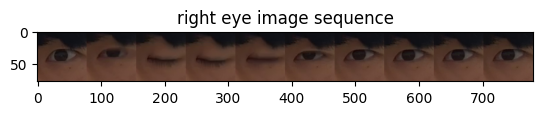

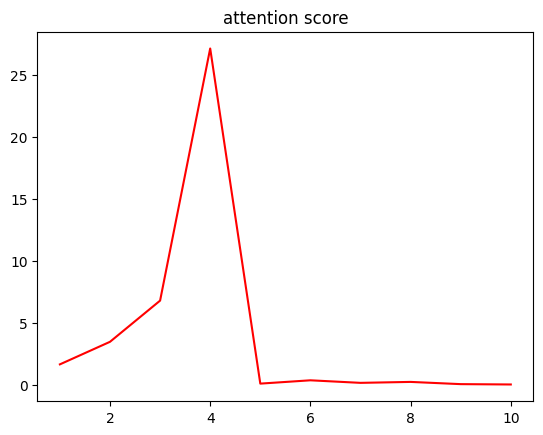

In [11]:
# visualize attention score
plt.imshow(cv2.cvtColor(r_img,cv2.COLOR_BGR2RGB))
plt.title("right eye image sequence")
plt.show()
plt.plot(range(1, len(r_att) + 1), r_att, 'r')
plt.title("attention score")
plt.show()